# Shark Species Prediction using TensorFlow

### GDAA2010 - Data Mining Modelling Assignment #2
#### Cindy Lu | April 12, 2023

Bull Sharks and Great White Sharks are both apex predators and are vital parts of the marine ecosystems. While the Great Whites are widely recognized as 'dangerous' thanks to the Hollywood movies, the Bulls actually have higher chances of encounterment to humans due to the their wider range of habitats and are often misidentified as the Great Whites. 

In this notebook, an image-based Deep Nerual Network model using TensorFlow package will be trained to classify the Bulls and Great Whites. Read on and see how the model works and performs.

### 1. Load TensorFlow and Required Packages

GPU is not required to run this notebook, however it may enhance efficiency of model building. 

In [1]:
# Import packages
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, RootMeanSquaredError

In [2]:
# Optional step to check and configure GPU pipelines
tf.config.list_physical_devices('GPU')

# how to avoid out of memory errors using gpu-enable TF pipelines
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 2. Load and Prepare the Image Data

Labelled images of Bull Sharks and (Great) White Sharks are downloaded from a [Kaggle dataset](https://www.kaggle.com/datasets/larusso94/shark-species), as well as extracted from [Oceanwide Images](http://www.oceanwideimages.com/), and [Getty Images](https://www.gettyimages.ca/) using appropriate search keywords and the ['Download All Images'](https://chrome.google.com/webstore/detail/download-all-images/ifipmflagepipjokmbdecpmjbibjnakm?hl=en) extension. Files of each shark species are nested within its unique folder. A preliminary review of the images were completed to remove non-image files as well as inappropriate images (e.g. poster of all shark species, images of other animals, irrelevant vector files).

**Load Image Data**

In [3]:
# File path may need to be changed to reflect the correct data directory
# from google.colab import drive
# drive.mount('/content/drive')
data_dir = 'sharksdata'

In [4]:
# Verify if the image files are readable, and remove those that are not
image_exts = ['jpeg', 'jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

Image not in ext list sharksdata\bull\00000000.jpg
Image not in ext list sharksdata\bull\00000021.jpg
Image not in ext list sharksdata\bull\00000033.jpg
Image not in ext list sharksdata\bull\00000050.jpg
Image not in ext list sharksdata\bull\00000078.jpg
Image not in ext list sharksdata\bull\00000143.jpg
Image not in ext list sharksdata\white\00000055.jpeg
Image not in ext list sharksdata\white\00000063.jpg
Image not in ext list sharksdata\white\00000082.jpg
Image not in ext list sharksdata\white\00000086.jpg
Image not in ext list sharksdata\white\00000089.gif


**Transform Image Data to Tensor Batches**

In [5]:
# Convert image data into tensor batches
data = tf.keras.utils.image_dataset_from_directory(data_dir, labels='inferred', label_mode = 'int')

Found 655 files belonging to 2 classes.


In [6]:
# View number of files for each image class
class_names = data.class_names
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    file_names = os.listdir(class_dir)
    print(f"Number of files for {class_name}: {len(file_names)}")

Number of files for bull: 306
Number of files for white: 349


Note that there are slightly more white shark images than bull shark images, but the difference isn't too drastic so the dataset will be used as is.

**Visualize Image Samples**

In [7]:
# Read data
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

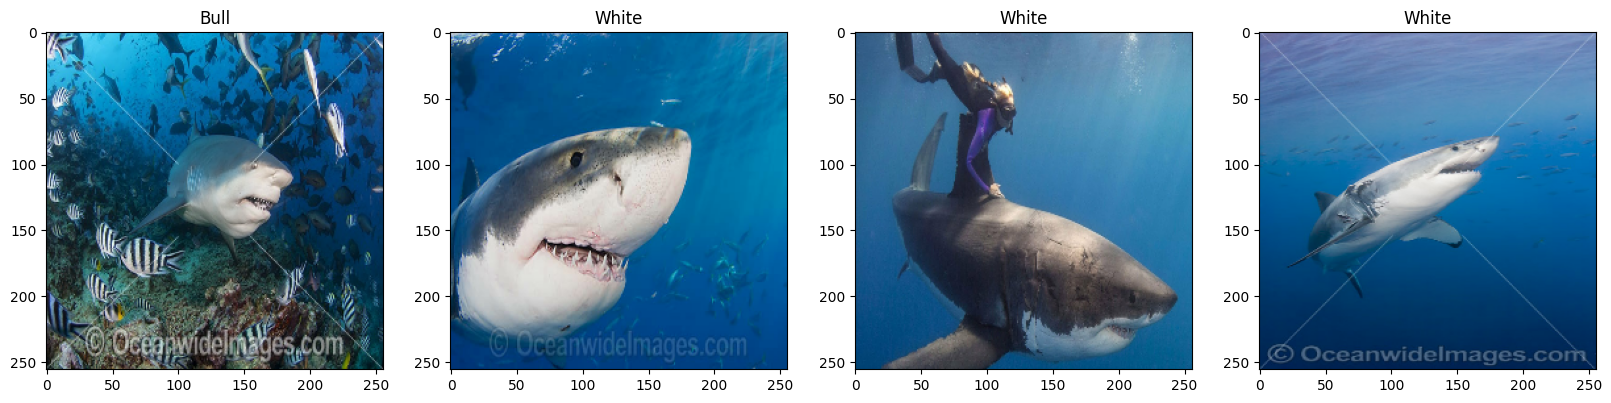

In [8]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    if batch[1][idx] == 0:
        label = 'Bull'
    else:
        label = 'White'
    ax[idx].title.set_text(label)


**Standardize Image Sizes by Rescaling**

In [9]:
# Apply a Lamda function object to normalize images
data = data.map(lambda x,y: (x/255, y))

# View the image data in numpy array format
data.as_numpy_iterator().next()

(array([[[[9.64705884e-01, 9.64705884e-01, 9.64705884e-01],
          [9.64705884e-01, 9.64705884e-01, 9.64705884e-01],
          [9.64705884e-01, 9.64705884e-01, 9.64705884e-01],
          ...,
          [1.14694394e-01, 3.59792441e-01, 4.67635572e-01],
          [1.36588544e-01, 3.79725784e-01, 4.77765024e-01],
          [1.44764856e-01, 3.87902111e-01, 4.85941321e-01]],
 
         [[9.64705884e-01, 9.64705884e-01, 9.64705884e-01],
          [9.64705884e-01, 9.64705884e-01, 9.64705884e-01],
          [9.64705884e-01, 9.64705884e-01, 9.64705884e-01],
          ...,
          [1.02029718e-01, 3.54963243e-01, 4.59869027e-01],
          [1.44113824e-01, 3.89188886e-01, 4.97039676e-01],
          [1.25536159e-01, 3.70611221e-01, 4.78462011e-01]],
 
         [[9.64705884e-01, 9.64705884e-01, 9.64705884e-01],
          [9.64705884e-01, 9.64705884e-01, 9.64705884e-01],
          [9.64705884e-01, 9.64705884e-01, 9.64705884e-01],
          ...,
          [1.37844667e-01, 3.96668196e-01, 4.9862

**Create Training/Validation/Test Data Splits**

The dataset will be split into a training set with 70% of data, a validation set with 20% of data, and a test set with 10% of data.

In [10]:
# Establish the training/validation/test split proportions (70% training, 20% validation, 10% test)
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

# Create the train/val/test datasets
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### 3. Train a Deep Learning Model

The Sequential model will be used in the followin steps, and will be built from various Sequential classes and activation functions.

In [11]:
# Instantiate the Sequential model
model_1 = Sequential()

In [12]:
# Define the neural net model layers
model_1.add(Conv2D(16, (3,3), 1, activation='relu', input_shape = (256,256,3)))
model_1.add(MaxPooling2D())
model_1.add(Conv2D(32, (3,3), 1, activation='relu'))
model_1.add(MaxPooling2D())
model_1.add(Conv2D(16, (3,3), 1, activation='relu'))
model_1.add(MaxPooling2D())
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(1, activation='sigmoid'))

**Model Evaluation Criteria**

Apply the 'Adam' optimizer, 'BindaryCrossentropy' loss function, and 'Accucary' as evaluation metrics.

In [13]:
# Compile model evaluation criteria
model_1.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# Review summary of the model setup
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

**Create a second Sequential Model**

The Gaussian Error Linear Unit (gelu) activation method will be used instead of the Rectified Linear Unit (relu). In the third 2D convolution layer, 64 output filters will be applied. Note the model is instantiated in a slightly different way than model 1 above, but either method works and it is related more to coding style.

In [14]:
model_2 = Sequential(
    layers=[Conv2D(16, (3,3), activation = 'gelu', input_shape = (256,256,3)),
            MaxPooling2D(2,2),
            Conv2D(32, (3,3), activation = 'gelu'),
            MaxPooling2D(2,2),
            Conv2D(64, (3,3), activation = 'gelu'),
            MaxPooling2D(2,2),
            Flatten(),
            Dense(512, activation = 'gelu'),
            Dropout(0.2),
            Dense(1, activation = 'sigmoid')]
)

In [15]:
model_2.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)      

Model 1 will be trained based on 3,696,625 parameters, while Model 2 will be trained on much larger number of parameters of 29,515,809. The more the merrier? Let's find out.

**Conduct Deep Neural Network Training**

The training dataset will go through 20 epochs where model parameters are tuned based on the outcome of a previous epoch.

*Model 1*

In [31]:
# # Alternatively, load previously saved model (uncomment the following codes)
# from tensorflow.keras.models import load_model
# model_3 = tf.keras.models.load_model(os.path.join('models','Shark_Classifier_1.h5'))

In [17]:
# Import the `time` package to time how long it takes for the model to run
import time

In [18]:
# Cross train the model with training dataset and validation dataset
start_time = time.time()
hist = model_1.fit(train, epochs=20, validation_data=val)
end_time = time.time()
run_time = end_time - start_time
print('Model completed in ', run_time, 'seconds.')

Epoch 1/20
14/14 [==============================] - 9s 579ms/step - loss: 0.6292 - accuracy: 0.6451 - val_loss: 0.5555 - val_accuracy: 0.7031
Epoch 2/20
14/14 [==============================] - 9s 577ms/step - loss: 0.4998 - accuracy: 0.7701 - val_loss: 0.4518 - val_accuracy: 0.8125
Epoch 3/20
14/14 [==============================] - 9s 575ms/step - loss: 0.4019 - accuracy: 0.8237 - val_loss: 0.3209 - val_accuracy: 0.8906
Epoch 4/20
14/14 [==============================] - 9s 575ms/step - loss: 0.3403 - accuracy: 0.8772 - val_loss: 0.3208 - val_accuracy: 0.8906
Epoch 5/20
14/14 [==============================] - 9s 587ms/step - loss: 0.2527 - accuracy: 0.8973 - val_loss: 0.3120 - val_accuracy: 0.8672
Epoch 6/20
14/14 [==============================] - 9s 620ms/step - loss: 0.2743 - accuracy: 0.8973 - val_loss: 0.2821 - val_accuracy: 0.8828
Epoch 7/20
14/14 [==============================] - 10s 645ms/step - loss: 0.1655 - accuracy: 0.9442 - val_loss: 0.2261 - val_accuracy: 0.9219
Epoch

*Model 2*

In [19]:
# # Alternatively, load previously saved model (uncomment the following codes)
# model_2 = tf.keras.models.load_model(os.path.join('models','Shark_Classifier_2.h5'))

In [20]:
start_time = time.time()
hist_2 = model_2.fit(train, epochs=20, validation_data=val)
end_time = time.time()
run_time = end_time - start_time
print('Model completed in ', run_time, 'seconds.')

Epoch 1/20
14/14 [==============================] - 20s 1s/step - loss: 0.8068 - accuracy: 0.6607 - val_loss: 0.4669 - val_accuracy: 0.7891
Epoch 2/20
14/14 [==============================] - 19s 1s/step - loss: 0.4128 - accuracy: 0.8170 - val_loss: 0.2441 - val_accuracy: 0.9062
Epoch 3/20
14/14 [==============================] - 19s 1s/step - loss: 0.3282 - accuracy: 0.8728 - val_loss: 0.3691 - val_accuracy: 0.8203
Epoch 4/20
14/14 [==============================] - 19s 1s/step - loss: 0.3464 - accuracy: 0.8438 - val_loss: 0.3616 - val_accuracy: 0.8125
Epoch 5/20
14/14 [==============================] - 19s 1s/step - loss: 0.3228 - accuracy: 0.8795 - val_loss: 0.2877 - val_accuracy: 0.8750
Epoch 6/20
14/14 [==============================] - 19s 1s/step - loss: 0.2443 - accuracy: 0.9018 - val_loss: 0.2929 - val_accuracy: 0.8828
Epoch 7/20
14/14 [==============================] - 19s 1s/step - loss: 0.2378 - accuracy: 0.8996 - val_loss: 0.3559 - val_accuracy: 0.8359
Epoch 8/20
14/14 [==

Both models were able to achieve validation accurary of over 99% in the last epoch. Processing times were similar for both models in GPU setting, but Model 2 took much longer in CPU setting possibly due to more parameters. In the next section, we will evaluate the model performance through change in accuracy and loss over each epoch, as well as through the test dataset.

### 4. Evaluate Model Performance

Plot the loss and accuracy values for each training epoch.

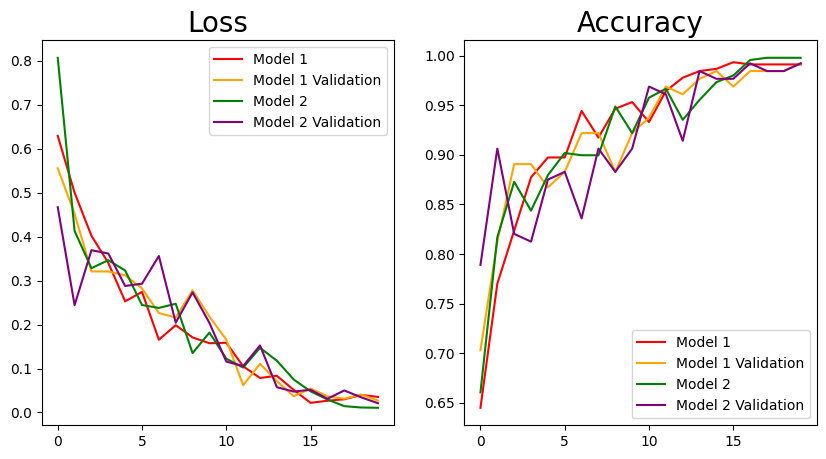

In [21]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

# Loss - difference between predicted and actual class labels
axs[0].plot(hist.history['loss'], color = 'red', label = 'Model 1')
axs[0].plot(hist.history['val_loss'], color = 'orange', label = 'Model 1 Validation')
axs[0].plot(hist_2.history['loss'], color = 'green', label = 'Model 2')
axs[0].plot(hist_2.history['val_loss'], color = 'purple', label = 'Model 2 Validation')
axs[0].set_title('Loss', fontsize=20)
axs[0].legend(loc='upper right')

# Accuracy - accuracy scores
axs[1].plot(hist.history['accuracy'], color = 'red', label = 'Model 1')
axs[1].plot(hist.history['val_accuracy'], color = 'orange', label = 'Model 1 Validation')
axs[1].plot(hist_2.history['accuracy'], color = 'green', label = 'Model 2')
axs[1].plot(hist_2.history['val_accuracy'], color = 'purple', label = 'Model 2 Validation')
axs[1].set_title('Accuracy', fontsize=20)
axs[1].legend(loc='lower right')

plt.show()

As seen in the plots, both models display upward accracy trends and downward loss trends for training and validation, indicating both were able to 'learn' and tune the parameters effectively. Interesting to note that the model performs differently in different virtual machine settings. The current output is generated from a local Python 3 kernel, where both models are comparable and it is difficult to determine which one performs better. When the models were trained in the Google Collab GPU environment, loss values for Model 2 were generally lower than those of Model 1, whereas accuracy values for Model 2 were generally higher than Model 1, suggesting that Model 2 potentially outperformed Model 1.

**Test the Model**

Model performance can be furter evaluated on the test dataset and measured with inherit TensorFlow metrics such as precision, recall, and accuracy values.

In [22]:
# Instantiate the metrics
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()
rmse = RootMeanSquaredError()

*Model 1*

In [23]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model_1.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)
    rmse.update_state(y,yhat)

print(f'Precision:{precision.result().numpy():.4f}, Recall:{recall.result().numpy():.4f}')
print(f'Accuracy:{accuracy.result().numpy():.4f}, RMSE:{rmse.result().numpy():.4f}')

1/1 [==============================] - 0s 84ms/step
Precision:1.0000, Recall:0.9643
Accuracy:0.9844, RMSE:0.0909


*Model 2*

In [24]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model_2.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)
    rmse.update_state(y,yhat)

print(f'Precision:{precision.result().numpy():.4f}, Recall:{recall.result().numpy():.4f}')
print(f'Accuracy:{accuracy.result().numpy():.4f}, RMSE:{rmse.result().numpy():.4f}')

1/1 [==============================] - 0s 257ms/step
Precision:1.0000, Recall:0.9692
Accuracy:0.9844, RMSE:0.0976


Note that the metrics may be different from different runs. But generally Model 2 produced higher precision, recall, accuracy scores than Model 1, based on the 2 test batches.

**Visual Inspection of Model Performance**

This model can be used to classify newly acquired images and identify whether the shark is a bull or white shark. This application is useful for validating encounterment reports, which often misclassify different shark species as white sharks.

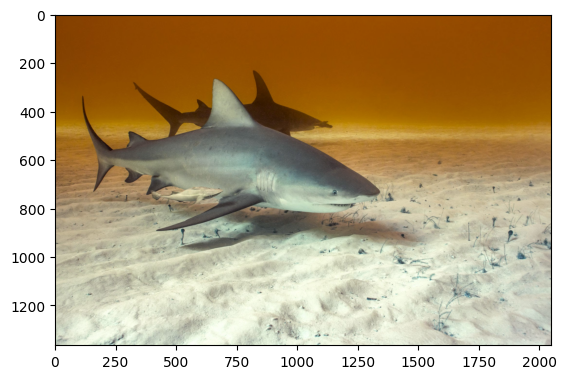

In [25]:
# Import a new image of bull shark
img = cv2.imread('test-bull.jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (256,256))

*Model 1*

In [26]:
# Predict the new image class
predicted_1 = model_1.predict(np.expand_dims(resize/255, 0))
print(predicted_1)
if predicted_1 > 0.5:
    print(f'Predicted class is White Shark')
else:
    print(f'Predicted class is Bull Shark')

1/1 [==============================] - 0s 50ms/step
[[7.560438e-06]]
Predicted class is Bull Shark


*Model 2*

In [27]:
predicted_2 = model_2.predict(np.expand_dims(resize/255, 0))
print(predicted_2)
if predicted_2 > 0.5:
    print(f'Predicted class is White Shark')
else:
    print(f'Predicted class is Bull Shark')

1/1 [==============================] - 0s 74ms/step
[[0.10255352]]
Predicted class is Bull Shark


Both Models successfully predicted the image to be Bull Shark. However Model 1 predicted the class more 'confidentally' as the value is much closer to 0 (the binary class label for Bull Shark). 

### 5. Save the Model

In [29]:
# Save Models
model_1.save(os.path.join('models','Shark_Classifier_1.h5'))
model_2.save(os.path.join('models','Shark_Classifier_2.h5'))

### Summary

The common approach to distinguish bull and white sharks is through their size and body color [[1]](https://fishingbooker.com/blog/bull-shark-vs-great-white-shark/#:~:text=The%20biggest%20giveaway%20is%20their,and%20clearly%20to%20white%20underneath), which may not be the most prominent features in images. 

I relied solely on the dataset quality and search keywords when setting up the image dataset, which may result in duplications and contamination with incorrect images. Despite my doubt, this notebook demonstrated that image classification workflow using the TensorFlow package can be effective in classifying the 2 shark species. The model performance may be further enhanced in the future with better quality training images.